In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
import os
print(os.environ['GOOGLE_API_KEY'][:10]+'*'*10)

AIzaSyC06D**********


In [4]:
from langchain_teddynote import logging

logging.langsmith("Naive RAG TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Naive RAG TEST


In [5]:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain import hub

# prompt_txt = """
# You are an AI assistant specializing in Question-Answering (QA) tasks within a Retrieval-Augmented Generation (RAG) system. 
# Your primary mission is to answer questions based on provided context or chat history.
# Ensure your response is concise and directly addresses the question without any additional narration.

# ###

# You may consider the previous conversation history to answer the question.

# # Here's the previous conversation history:
# {chat_history}

# ###

# Your final answer should be written concisely (but include important numerical values, technical terms, jargon, and names), followed by the source of the information.

# # Steps

# 1. Carefully read and understand the context provided.
# 2. Identify the key information related to the question within the context.
# 3. Formulate a concise answer based on the relevant information.
# 4. Ensure your final answer directly addresses the question.
# 5. List the source of the answer in bullet points, which must be a file name (with a page number) or URL from the context. Omit if the answer is based on previous conversation or if the source cannot be found.

# # Output Format:
# [Your final answer here, with numerical values, technical terms, jargon, and names in their original language]

# **Source**(Optional)
# - (Source of the answer, must be a file name(with a page number) or URL from the context. Omit if the answer is based on previous conversation or can't find the source.)
# - (list more if there are multiple sources)
# - ...

# ###

# Remember:
# - It's crucial to base your answer solely on the **provided context** or **chat history**. 
# - DO NOT use any external knowledge or information not present in the given materials.
# - If a user asks based on the previous conversation, but if there's no previous conversation or not enough information, you should answer that you don't know.

# ###

# # Here is the user's question:
# {question}

# # Here is the context that you should use to answer the question:
# {context}

# # Your final answer to the user's question:
# """

# prompt = ChatPromptTemplate.from_template(prompt_txt)
# hub.push("naive_rag_gemni", prompt)

In [6]:
from langchain_core.prompts import load_prompt, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.pydantic_v1 import BaseModel, Field

from abc import ABC, abstractmethod
from operator import itemgetter
from langchain import hub


class RetrievalChain(ABC):
    def __init__(self):
        self.source_uri = None
        self.k = 10
        self.prompt_name = "naive_rag_gemni"
    @abstractmethod
    def load_documents(self, source_uris):
        """loader를 사용하여 문서를 로드합니다."""
        pass

    @abstractmethod
    def create_text_splitter(self):
        """text splitter를 생성합니다."""
        pass

    def split_documents(self, docs, text_splitter):
        """text splitter를 사용하여 문서를 분할합니다."""
        return text_splitter.split_documents(docs)

    def create_embedding(self):
        return OllamaEmbeddings(model="bge-m3")
    
    def create_embdding_eng(self):
        return GoogleGenerativeAIEmbeddings(model="text-embedding-004")

    def create_vectorstore(self, split_docs, inlang = "ko"):
        if inlang == "ko":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embedding()
            )
        elif inlang == "eng":
            return FAISS.from_documents(
                documents=split_docs, embedding=self.create_embdding_eng()
            )

    def create_retriever(self, vectorstore):
        # MMR을 사용하여 검색을 수행하는 retriever를 생성합니다.
        dense_retriever = vectorstore.as_retriever(
            search_type="similarity", search_kwargs={"k": self.k}
        )
        return dense_retriever

    def create_model(self):
        # return ChatOllama(model_name="dnotitia/dna", temperature=0)
        return ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

    def create_prompt(self):
        return hub.pull(self.prompt_name)

    @staticmethod
    def format_docs(docs):
        return "\n".join(docs)

    def create_chain(self, inlang = "ko"):
        docs = self.load_documents(self.source_uri)
        text_splitter = self.create_text_splitter()
        split_docs = self.split_documents(docs, text_splitter)
        self.vectorstore = self.create_vectorstore(split_docs, inlang)
        self.retriever = self.create_retriever(self.vectorstore)
        model = self.create_model()
        prompt = self.create_prompt()
        self.chain = (
            {
                "question": itemgetter("question"),
                "context": itemgetter("context"),
                "chat_history": itemgetter("chat_history"),
            }
            | prompt
            | model
            | StrOutputParser()
        )
        return self

c:\Users\최인규\Documents\RAG_practice\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing import List, Annotated


class MarkdownRetrievalChain(RetrievalChain):
    def __init__(self, source_uri: Annotated[str, "Source URI"], prompt_name = "naive_rag_gemni"):
        self.source_uri = source_uri
        self.k = 10
        self.prompt_name = prompt_name

    def load_documents(self, source_uris: List[str]):
        docs = []
        for source_uri in source_uris:
            loader = TextLoader(source_uri, encoding='utf-8')
            docs.extend(loader.load())

        return docs

    def create_text_splitter(self):
        return RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [8]:
# PDF 문서를 로드합니다.
md = MarkdownRetrievalChain(["../data/2025 KB 부동산 보고서_analyzed.md"]).create_chain(inlang="ko")

# retriever와 chain을 생성합니다.
md_retriever = md.retriever
md_chain = md.chain

In [9]:
import pandas as pd
from datasets import load_dataset, Dataset
import os

# huggingface Dataset에서 repo_id로 데이터셋 다운로드
dataset = load_dataset(
    "copycatQ/ragas_practice_dataset",  # 데이터셋 이름
    token=os.environ["HUGGINGFACEHUB_API_TOKEN"],  # private 데이터인 경우 필요합니다.
)

# 데이터셋에서 split 기준으로 조회
huggingface_df = dataset["korean_estate"].to_pandas()
huggingface_df.head()

,user_input,reference_contexts,reference,synthesizer_name,validity,reference_context_relevance,qa_appropriateness,__index_level_0__
0,송도의 부동산 시장에서 최근의 주요 이슈는 무엇인가요?,[정비 지역 광명 재건축 사업 진행 이후 신축 단지에 관심 집중. 수요가 감소하는 ...,"송도에서는 GTX 건설 추진 지연으로 기대감이 감소하고 있으며, 제약·바이오 산업 ...",single_hop_specifc_query_synthesizer,True,True,True,0
1,2023년 부동산 시장에서 어떤 주요 변화가 있었나요?,[정비 지역 광명 재건축 사업 진행 이후 신축 단지에 관심 집중. 수요가 감소하는 ...,2023년 부동산 시장은 상업용 부동산 거래량이 2022년 대비 11.6% 감소하여...,single_hop_specifc_query_synthesizer,True,True,True,1
2,2023년 상업용 부동산 시장의 주요 동향은 무엇인가요?,[정비 지역 광명 재건축 사업 진행 이후 신축 단지에 관심 집중. 수요가 감소하는 ...,2023년 상업용 부동산 시장은 거래량이 2024년에는 11.6% 감소한 4.6만 ...,single_hop_specifc_query_synthesizer,True,True,True,2
3,2024년 주택시장에 대한 분석 결과는 무엇인가요?,[2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 Ex ecutive...,2024년 주택 매매가격은 3분기 이후 상승세를 보였으나 4분기 들어 상승폭이 크게...,single_hop_specifc_query_synthesizer,True,True,True,3
4,압구정의 주택시장 상황은 어때요?,[2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 Ex ecutive...,"압구정은 재건축 단지의 사업 진행 상황이 시장에 큰 영향을 미치고 있으며, 서울 2...",single_hop_specifc_query_synthesizer,True,True,True,4


In [13]:
test_sample=next(huggingface_df.itertuples())

In [ ]:
test_sample.user_input

'송도의 부동산 시장에서 최근의 주요 이슈는 무엇인가요?'

In [15]:
search_result = md_retriever.invoke(test_sample.user_input)
print('\n\n'.join([doc.page_content for doc in search_result]))

수요 회복의 원인으로는 삼성바이오로직스, SK바이오사이언스, 롯데바이오로직스, 셀트리온과 같은 국 내외 제약 및 바이오 기업의 연구개발시설 및 제조시설 입주에 따른 실수요의 증가를 들 수 있다. 송도 의 대표 아파트인 '더샵퍼스트파크'의 매매가격도 전용면적 84㎡ 기준 2024년 연초 10.3억 원에서 연 말 11억 원으로 상승하였다. 2024년 서울과 경기 지역 매매가격이 보합세를 보이거나 하락한 상황에서 서울 접근성이 떨어진다는 점과 많은 공급물량 등을 감안할 때 2024년 송도 주택시장은 다소 긍정적 인 모습을 보였다.

과거 송도 내의 주택 수요는 GTX 추진으로 급증하였으나 향후에는 기업 입주로 인한 실수요의 영향 이  클  수  있으며, 2025년에는  정부의  대출  규제나  금리  등  실수요에  영향을  주는  요소들의  중요성이 더욱 커질 것으로 예상된다.

Part

2025 KB부동산 보고서: 상업용 부동산시장 진단과 전망

### 이미지 분석
**지도 및 다이어그램**
- 송도국제도시의 개발 호재를 나타내는 지도입니다.
- 주요 건물인 '셀트리온'과 '삼성바이오로직스'가 강조되어 있습니다.
- GTX-B 노선이 인천대교역과 연결되어 있어 교통 편의성이 증대됩니다.
- 지도에서 나타난 주요 지점들은 송도 지역의 발전 가능성을 시사합니다.
- 전반적으로 송도국제도시의 미래 개발 계획과 중요한 인프라를 나타냅니다.


자료: 카카오맵, 삼성바이오로직스, 셀트리온, KB부동산 재인용

GTX-B 노선 사업 지연에도 불구하고 2024년 송도 지역의 주택 수요는 다소 회복되는 모습을 보였 다. 송도 지역의 마지막 개발 구역인 11공구에서 2024년 2월에 분양한 '송도자이풍경채그라노블'은 전 용면적 84㎡ 기준 분양가가 8.5억 원으로 당시 미분양물량이 적지 않았으나, 2분기 이후 매매 거래가 증가하면서 하반기 들어 분양이 완료되었다.

자료: 《 매일경제 》

송도 지역은 2019년 GTX-B 노선의 예비타당성 조사가 통과된 이후 서울 도심 접근

In [16]:
# 검색 결과를 기반으로 답변을 생성합니다.
answer = md_chain.invoke(
    {
        "question": test_sample.user_input,
        "context": search_result,
        "chat_history": [],
    }
)
print(answer)

송도 부동산 시장의 주요 이슈는 GTX 건설 추진 지연으로 인한 기대감 감소와 제약·바이오 산업 유입에 따른 수요 증가입니다.
**Source**
- ../data/2025 KB 부동산 보고서_analyzed.md


In [10]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [11]:
def format_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc.page_content}</content><source>{doc.metadata['source']}</source><page>{int(doc.metadata['page'])+1}</page></document>"
            for doc in docs
        ]
    )


def format_searched_docs(docs):
    return "\n".join(
        [
            f"<document><content>{doc['content']}</content><source>{doc['url']}</source></document>"
            for doc in docs
        ]
    )


def format_task(tasks):
    # 결과를 저장할 빈 리스트 생성
    task_time_pairs = []

    # 리스트를 순회하면서 각 항목을 처리
    for item in tasks:
        # 콜론(:) 기준으로 문자열을 분리
        task, time_str = item.rsplit(":", 1)
        # '시간' 문자열을 제거하고 정수로 변환
        time = int(time_str.replace("시간", "").strip())
        # 할 일과 시간을 튜플로 만들어 리스트에 추가
        task_time_pairs.append((task, time))

    # 결과 출력
    return task_time_pairs


In [ ]:
from langchain_teddynote.messages import messages_to_history


# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = md_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": retrieved_docs}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # 체인을 호출하여 답변을 생성합니다.
    response = md_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response,
        "messages": [("user", latest_question), ("assistant", response)],
    }

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

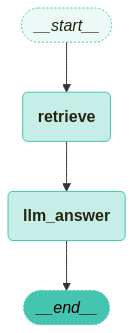

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="2024년 부동산 시장 트렌드는?")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
<document><content>1 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 1 
 2025년 주택시장 하향 안정, 정부 정책 방향이 중요한 한 해가 될 전망 
주택시장은 2022년 하반기 이후 상승과 하락을 반복하는 상황이 지속되고 있다. 이러한 시장 흐름은 
올해도 이어질 것으로 보인다. 높은 가격에 대한 부담, 대출 규제 등의 하락 요인과 함께 공급 부족, 금리 인하 
등의 상승 요인이 혼재되어 있기 때문이다. 다만, 선호도에 따른 지역별 차별화 현상은 더욱 확대될 수 있다.   
올해 주택시장의 가장 큰 변수는 정부의 정책이 될 가능성이 높다. 지난해 하반기 시장 흐름에서 볼 수 
있듯이, 실수요자 중심인 현재의 주택시장에서 대출 규제의 영향은 상당히 크다. 올해 주택시장의 또 다른 
변수는 주택 공급이 될 수 있다. 공사비 증가, 부동산 프로젝트파이낸싱(PF) 시장 경색으로 민간 공급이</content><source>../data/2025 KB 부동산 보고서.pdf</source><page>2</page></document>
<document><content>2 
2024 KB 부동산 보고서: 2024년 주택시장 진단과 전망 
 
 
 
Executive Summary 2 
 2025년 주택시장 전망은 하락 의견이 우세, 올해 하반기 또는 내년 반등 예상  
• 주택 매매가격은 비수도권은 하락 전망, 수도권은 의견이 엇갈림 
2025년 전국 주택 매매가격에 대해 부동산전문가(62%), 공인중개사(79%), 자산관리전문가(PB, 62%) 모두 
하락 전망이 우세하였다. 지역별로 보면 비수도권에 대해서는 하락 전망으로 의견이 일치하였으나 
수도권에 대해서는 조사 집단별로 의견이 엇갈렸다. 부동산전문가는 상승 전망이 54%로, 공인중개사는 
하

In [16]:
# 그래프를 스트리밍 출력
stream_graph(app, inputs, config)


🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
2024년 주택시장은 상승과 하락을 반복하는 혼조세가 나타났으며, 하락-상승-하락으로 이어지며 시장 방향성에 대한 혼란이 가중되었습니다. 2024년 주택 매매 거래량은 64.2만 호로 전년 대비 15.8% 증가했지만, 2012~2021년 평균의 66.0% 수준에 불과했습니다. 2024년 주택 전세가격은 전년 대비 1.4% 상승했습니다.

**Source**
- ../data/2025 KB 부동산 보고서.pdf, page 7
- ../data/2025 KB 부동산 보고서.pdf, page 8

In [17]:
outputs = app.get_state(config).values

print(f'Question: {outputs["question"]}')
print("===" * 20)
print(f'Answer:\n{outputs["answer"]}')

Question: 2024년 부동산 시장 트렌드는?
Answer:
2024년 주택시장은 상승과 하락을 반복하는 혼조세가 나타났으며, 하락-상승-하락으로 이어지며 시장 방향성에 대한 혼란이 가중되었습니다. 2024년 주택 매매 거래량은 64.2만 호로 전년 대비 15.8% 증가했지만, 2012~2021년 평균의 66.0% 수준에 불과했습니다. 2024년 주택 전세가격은 전년 대비 1.4% 상승했습니다.

**Source**
- ../data/2025 KB 부동산 보고서.pdf, page 7
- ../data/2025 KB 부동산 보고서.pdf, page 8
